<a href="https://colab.research.google.com/github/dfreire770/dq-ddq-smb-agent/blob/main/Mario_Test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a modified version of the DQN tutorial from here:

https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=jbY4yrjTEyc9

But, instead of Cartpole, it uses Super Mario Bros.

The purpose of this is simply for an initial test of whether the DQN method can be used here in this fashion.

In [ ]:

!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
!pip install tf-keras

!pip install gym==0.26.2
!pip install gym-notices==0.0.8
!pip install gymnasium==0.29.1
!pip install gym-super-mario-bros==7.4.0
!pip install moviepy
!pip install ffmpeg-python==0.2.0

This is a modified version of the DQN tutorial from here:

https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=jbY4yrjTEyc9

But, instead of Cartpole, it uses Super Mario Bros

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [61]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common


import gym_super_mario_bros
import gym.wrappers
import gym
import cv2
import os
import numpy as np
import glob

from IPython.display import HTML
from IPython.display import Video
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace
from base64 import b64encode

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [5]:
tf.version.VERSION

'2.15.0'

In [6]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [41]:
env = gym_super_mario_bros.make('SuperMarioBros-v0',
                             apply_api_compatibility=True,
                                render_mode="rgb_array")

#env_name = 'SuperMarioBros-v0'
#env = suite_gym.load(env_name)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


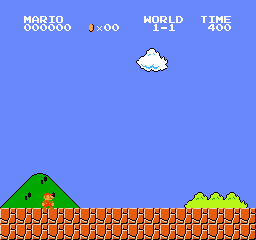

In [42]:
env.reset()
PIL.Image.fromarray(env.render())

In [62]:
class GymWrapper(py_environment.PyEnvironment):
    def __init__(self, gym_env):
        super(GymWrapper, self).__init__()
        self._gym_env = gym_env
        self._action_spec = self._get_action_spec()
        self._observation_spec = self._get_observation_spec()
    def _get_action_spec(self):
        action_space = self._gym_env.action_space
        if isinstance(action_space, gym.spaces.Box):
            return array_spec.BoundedArraySpec(
                shape=action_space.shape,
                dtype=action_space.dtype,
                minimum=action_space.low,
                maximum=action_space.high
            )
        elif isinstance(action_space, gym.spaces.Discrete):
            return array_spec.BoundedArraySpec(
                shape=(),
                dtype=action_space.dtype,
                minimum=0,
                maximum=action_space.n-1
            )
        else:
            raise ValueError(f"Unsupported action space type: {type(action_space)}")

    def _get_observation_spec(self):
        observation_space = self._gym_env.observation_space
        return array_spec.ArraySpec(
            shape=observation_space.shape,
            dtype=observation_space.dtype
        )

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        return ts.restart(self._gym_env.reset())

    def _step(self, action):
        obs, reward, done, info = self._gym_env.step(action)
        if done:
            return ts.termination(obs, reward)
        else:
            return ts.transition(obs, reward)

In [57]:
print('Observation Spec:')
print(GymWrapper(env).time_step_spec().observation)

Observation Spec:
ArraySpec(shape=(240, 256, 3), dtype=dtype('uint8'), name=None)


In [58]:
print('Reward Spec:')
print(GymWrapper(env).time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [59]:
print('Action Spec:')
print(GymWrapper(env).action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=255)


In [63]:
observation, info = env.reset()
print('Time step:')
print(observation, info)

'''
time_step = env.reset()
print('Time step:')
print(time_step)
'''

action = np.array(1, dtype=np.int32) # original comes with the other program but only returns 4 instead of 5
#action = env.action_space.sample()


observation, reward, terminated, truncated, info =  env.step(action)
print('Next time step:')
print(observation, reward, terminated, truncated, info)

'''
step_type, reward, discount, observation = env.step(action)
print('Next time step:')
print(step_type, reward, discount, observation )
'''

Time step:
[[[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 ...

 [[240 208 176]
  [228  92  16]
  [228  92  16]
  ...
  [228  92  16]
  [228  92  16]
  [  0   0   0]]

 [[240 208 176]
  [228  92  16]
  [228  92  16]
  ...
  [228  92  16]
  [  0   0   0]
  [  0   0   0]]

 [[228  92  16]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [228  92  16]]] {}
Next time step:
[[[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 ...

 [[240 208 176]
  [228

"\nstep_type, reward, discount, observation = env.step(action)\nprint('Next time step:')\nprint(step_type, reward, discount, observation )\n"

In [67]:
train_py_env = GymWrapper(env)
eval_py_env = GymWrapper(env)
# using GymWrapper function above in order to be able to use tensorflow next

In [68]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)
# converting into tensorflow enviornment

In [69]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(GymWrapper(env).action_spec())
# need GymWrapper(env) rather than just env
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

**TODO** - Fix following error -

'ValueError: Expected q_network to emit a floating point tensor with inner dims (256,); but saw network output spec: TensorSpec(shape=(240, 256, 256), dtype=tf.float32, name=None)
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)'

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

ValueError: Expected q_network to emit a floating point tensor with inner dims (256,); but saw network output spec: TensorSpec(shape=(240, 256, 256), dtype=tf.float32, name=None)
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)